In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

#定义超参数
image_size = 28  # image size 28*28
num_classes = 10 # 标签的种类
num_epochs = 20  # 训练的循环周期 20
batch_size = 64  # 一个批次的大小，64张图片

(1, 28, 28)
训练集多少批： 938
训练集总共多少条： 60000
校验集多少批： 79
校验集总共多少条： 10000
测试集多少批： 79
测试集总共多少条： 10000 

The label is:  5


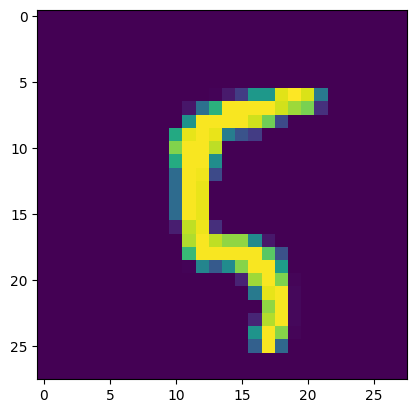

The label is:  7


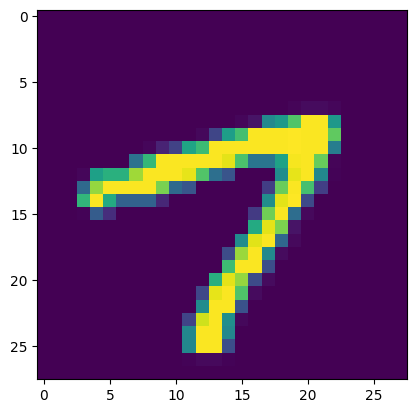

The label is:  1


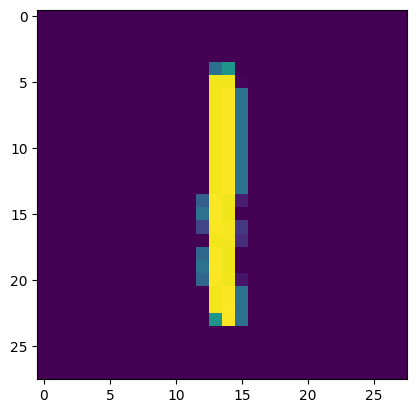

In [103]:
train_datasets = dsets.MNIST(root='./5_convolution_data', # 文件存放路径
                             train = True,  # 提取训练集
                             transform=transforms.ToTensor(), #将图像转化为Tensor
                             download = True)  # 找不到文件的时候自动下载
print(train_datasets[0][0].data.numpy().shape)

# 加载测试数据集
test_datasets = dsets.MNIST(root='./5_convolution_data', # 文件存放路径
                             train = False,  # 提取训练集
                             transform=transforms.ToTensor(),) #将图像转化为Tensor
                           
#  自动将数据切分成批，打乱顺序
train_loader = torch.utils.data.DataLoader(dataset = train_datasets,
                                           batch_size = batch_size,
                                           shuffle = True)
print('训练集多少批：', len(train_loader))
print('训练集总共多少条：', len(train_loader.dataset))

# 测试数据分为两部分，一部分校验用验证是否过拟合，一部分测试
indices = range(len(test_datasets))
indices_validate = indices[:5000]
indices_test = indices[5000:]

# 数据采样器
sampler_validate = torch.utils.data.sampler.SubsetRandomSampler(indices_validate)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据采样器定义加载器
validate_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              sampler = sampler_validate)
                                             
test_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              sampler = sampler_test)
print('校验集多少批：', len(validate_loader))
print('校验集总共多少条：', len(validate_loader.dataset))
print('测试集多少批：', len(test_loader))
print('测试集总共多少条：', len(test_loader.dataset), '\n')

def show_raw_img(idx):
    muteimg = train_datasets[idx][0].data.numpy()
    plt.imshow((muteimg[0,...]))   # 因为维度是1*28*28，  所以切片的第一维度索引是0， 即提取 28*28 
    print('The label is: ', train_datasets[idx][1])
    plt.show()
                                           
# 随便从数据集中读入一张图片
show_raw_img(100)
show_raw_img(101)
show_raw_img(102)

In [47]:
# 构建卷积神经网络
depth = [4, 8] # 卷积层的厚度

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()  # 调用父类构造函数

        # 卷积后图像维度不变， size + padding * 2 - kernel_size + 1 = size + 4 - 5 + 1 = size
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 5, padding = 2) # 卷积层
        
        self.pool = nn.MaxPool2d(2, 2) #  池化层
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) # 第二层卷积

        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512) 
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # 神经网络完成真正的前向运算，拼装各个实际的组件
        x = self.conv1(x) # 第一层卷积
        x = F.relu(x)  # (batch_size, num_filters, image_width, image_height]

        x = self.pool(x) # 第二层池化，图片变小：(batch_size, num_filters, image_width / 2, image_height / 2]

        x = self.conv2(x) #第三层卷积, (batch_size, depth[1], image_width / 2, image_height / 2]
        x = F.relu(x)  

        x = self.pool(x) #第四层池化， 图片缩小 (batch_size, depth[1], image_width / 2 / 2, image_height / 2 / 2]

        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])  # 压缩向量

        x = F.relu(self.fc1(x)) # 第五层为全连接  (batch_size, 512)

        x = F.dropout(x, training = self.training) # 默认以0.5的概率对这一层进行dropout操作，防止过拟合
        x = self.fc2(x)  # 全连接层，最终输出 （batch_size, num_classes）

        x = F.log_softmax(x, dim=1)
        return x

    def retrieve_features(self, x):
        # 返回前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)

        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
        
# 计算分类准确度
def rightness(predictions, labels):
    # max函数返回[value, index], pred得到最大概率的索引，0表示好，1表示负面
    pred = torch.max(predictions.data, 1)[1] # max的dim=1 表示沿着第二个维度计算max，即好或坏两个分类数值， 

    rights = pred.eq(labels.data.view_as(pred)).sum()

    return rights, len(labels)

In [ ]:
net = ConvNet() # 自动调用实例的init函数

criterion = nn.CrossEntropyLoss() # 定义损失函数
# 动量法每下降一步都是由前面下降方向的一个累积和（衰减系数momentum）当前点的梯度方向组合而成。
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 定义优化器, 小批量loss更新的梯度下降算法。 momentum动量法

records = [] # 记录一个epoch周期内训练集和校验集的准确率
weights = []

for epoch in range(num_epochs):
    train_rights = []
    # data维度: [64, 1, 28, 28], target维度: [64], target存储的是索引值
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # train()方法是用于在训练神经网络时启用dropout、batch normalization和其他特定于训练的操作的函数。
        net.train()
        
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad() # 清空梯度 
        loss.backward()
        optimizer.step()  # 随机梯度下降算法更新权重

        right = rightness(output, target) # 计算准确率
        train_rights.append(right)

        if batch_idx % 100 == 0:
            net.eval() # 不运行dropout，BN等训练层
            validate_rights = []

            for (data, target) in validate_loader:
                output = net(data)
                
                right = rightness(output, target)
                validate_rights.append(right)

            # 训练集准确度=train_r[0] / train_r[1]
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            # 校验集准确度=validate_r[0] / validate_r[1]
            validate_r = (sum([tup[0] for tup in validate_rights]), sum([tup[1] for tup in validate_rights]))

            # 计算一个epoch周期内的 准确率
            # 训练周期: 0 [12800 / 60000 (21%)]	, Loss: 2.259433	, 训练正确率: 14.70%	, 校验正确率: 30.50%
            print('训练周期: {} [{} / {} ({:.0f}%)]\t, Loss: {:.6f}\t, 训练正确率: {:.2f}%\t, 校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.data,
                100. * train_r[0] / train_r[1],
                100. * validate_r[0] / validate_r[1]
            ))

            records.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * validate_r[0] / validate_r[1]))
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                           net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])

In [49]:
# 测试模型
net.eval() # 标志模型当前是运行阶段

vals = []
for data, target in test_loader:
    output = net(data)
    val = rightness(output, target)
    vals.append(val)

# 计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]

print(right_rate)

tensor(0.9898)


Text(0, 0.5, 'Error rate')

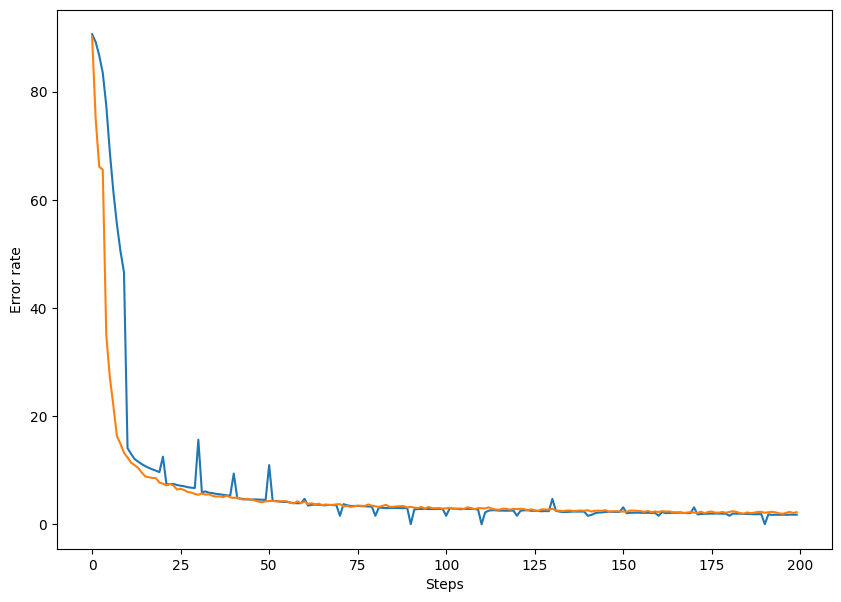

In [50]:
# 打印训练集和验证集的准确率曲线
plt.figure(figsize=(10,7))
plt.plot(records)
plt.xlabel('Steps')
plt.ylabel('Error rate')

[[ 0.2776114   0.14610735  0.1853075   0.0227048  -0.23491177]
 [ 0.37486333  0.27882725 -0.08333924 -0.06440972 -0.28737837]
 [ 0.3891697   0.15196924 -0.2636026  -0.08956173 -0.16837098]
 [ 0.24104674  0.31010583  0.03989693 -0.07522833  0.03356412]
 [ 0.30821556  0.09673616 -0.18877591 -0.08898567 -0.06884556]]
[[ 0.01538564  0.24022901  0.31109163  0.235073    0.06762021]
 [ 0.20201764  0.17623849  0.21206993  0.32630122  0.0099622 ]
 [-0.1640214  -0.15714584 -0.19413945 -0.20327273  0.08958226]
 [-0.1030174  -0.26672918 -0.16204707 -0.24425434 -0.05271962]
 [-0.08002462 -0.10437884 -0.07741079 -0.02363325 -0.02737902]]
[[ 0.1295999   0.25993702  0.3230741   0.4091115   0.38658065]
 [-0.05662829  0.07844602  0.3012332   0.32786822  0.3933419 ]
 [-0.17677681  0.15098648  0.2312583   0.28013998  0.31951967]
 [-0.24614598 -0.21607405 -0.12024488  0.17207716  0.12339077]
 [ 0.01330433 -0.2672198   0.10140539  0.00876099 -0.02797508]]
[[ 0.06018297  0.03030153 -0.05664835 -0.15680672 -0

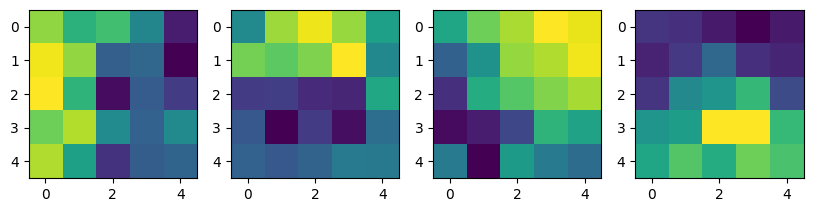

In [110]:
# 打印第一层卷积核及其图像表示
plt.figure(figsize=(10, 7))

# 4个输出通道
for i in range(4):
    plt.subplot(1, 4, i + 1)
    print(net.conv1.weight.data.numpy()[i, 0, ...])
    plt.imshow(net.conv1.weight.data.numpy()[i, 0, ...])

[[-0.09098253 -0.05014398 -0.0450108   0.06861466 -0.069616  ]
 [-0.11273351 -0.03081075  0.19663545  0.05466999  0.05108086]
 [ 0.02985285 -0.02577298  0.26521343  0.05407143 -0.0255492 ]
 [-0.09574652  0.06820833  0.13038638  0.08826172 -0.03660779]
 [-0.02213265  0.06747559  0.07707048  0.02942744  0.09915602]]
[[-0.03058252 -0.03961559 -0.0391105   0.05783853 -0.0866335 ]
 [-0.06047077  0.02138211  0.04571432 -0.06121389  0.04489453]
 [ 0.03558509 -0.12795949 -0.14636058 -0.02430205  0.05656724]
 [-0.03272703 -0.01023682  0.02394683 -0.05026034 -0.03941142]
 [-0.09557434 -0.0671382  -0.10076336 -0.01045626 -0.02863272]]
[[-0.11212076  0.01690113 -0.07897921  0.02434212 -0.05156942]
 [ 0.03868352 -0.00757189 -0.0776833   0.04718696  0.0630596 ]
 [ 0.11999515  0.03881219 -0.07105177 -0.08250045 -0.08963973]
 [ 0.18050522  0.07195571 -0.11206904 -0.16169193  0.03180448]
 [ 0.13677393  0.17721108 -0.05123663 -0.06147385 -0.08568919]]
[[ 0.00520199  0.1814275   0.23202519 -0.00676287 -0

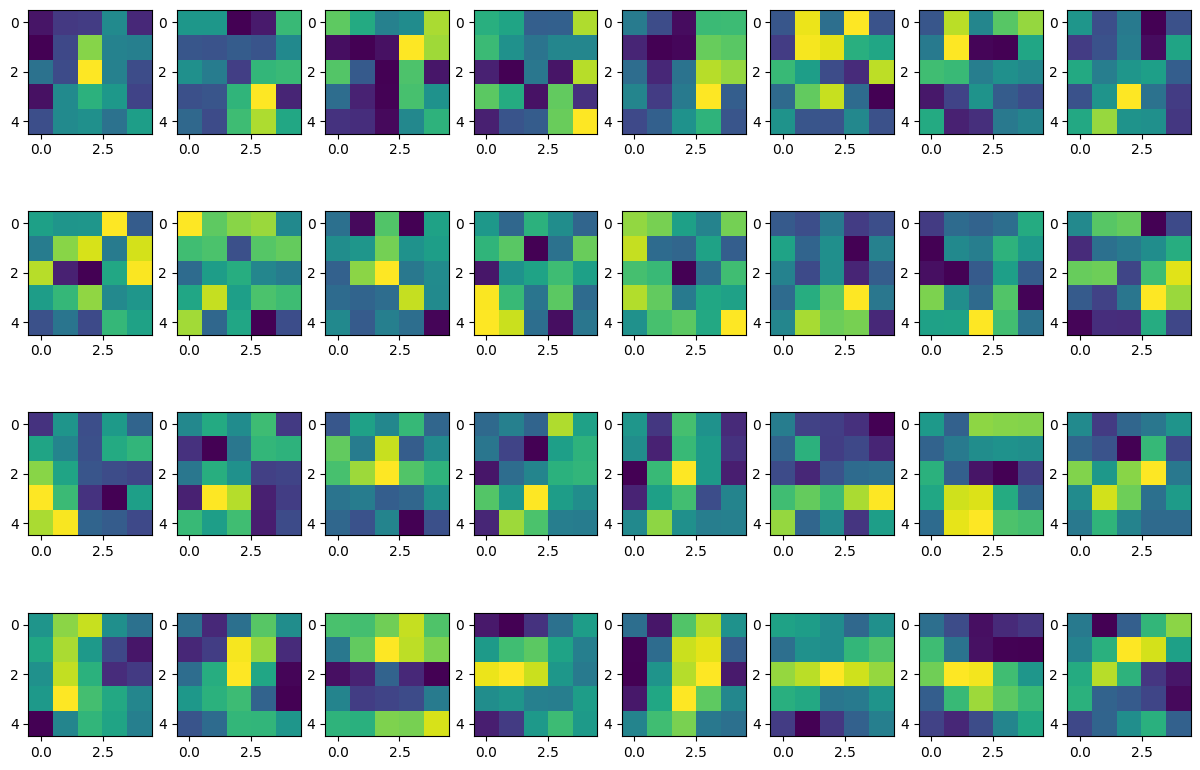

In [116]:
# 打印第二层卷积核及其图像表示
plt.figure(figsize=(15, 10))

# 4个输入通道，8个输出通道
for i in range(4):
    print(net.conv2.weight.data.numpy()[0, i, ...])  # 仅打印对应第一个输出通道的第一个卷积核， 卷积核的权重对应了4个输入通道
    for j in range(8):
        # 注意： 每一列对应了一个卷积核，一共有8个卷积核
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.imshow(net.conv2.weight.data.numpy()[j, i, ...])

torch.Size([1, 8, 14, 14])


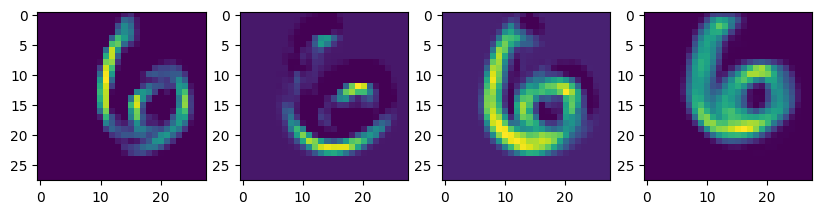

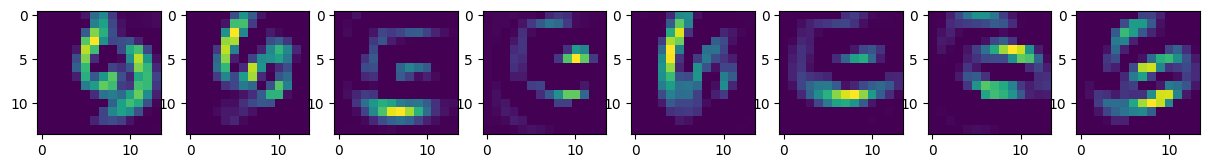

In [113]:
# 仅仅观察卷积核或其图像很难观察到什么，需要结合输入与卷积核 生成特征图
idx = 100
input_x = test_datasets[idx][0].unsqueeze(0) # unsquezze(0)：表示在第0维增加一个维度，最终变成[1, 1, 28, 28], 

feature_maps = net.retrieve_features(input_x) # 打印两个卷积层的输出
print(feature_maps[1].shape)

# 第一层卷积的特征图 (out_channels = 4)
out_channels = 4
plt.figure(figsize=(10, 7))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[0][0, i, ...].data.numpy())

# 第二层卷积的特征图（out_channels = 8）
out_channels = 8
plt.figure(figsize=(15, 10))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[1][0, i, ...].data.numpy())

Original Image:


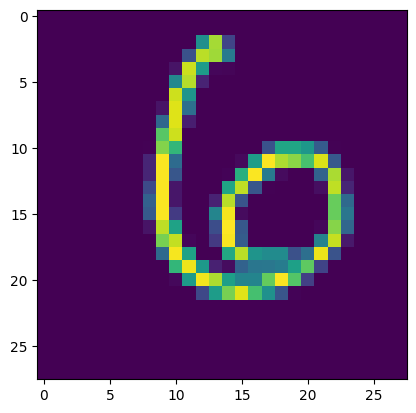

Shift to left Image:


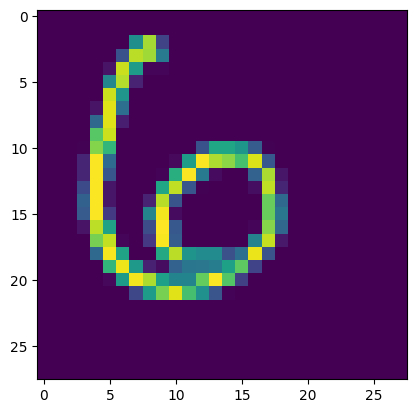

In [133]:
# 卷积神经网络的健壮性实验
# 随机挑选一张图片，平移w个单位，考察分类结果是否有变化

idx = 100
a = test_datasets[idx][0][0]  # shape: [28, 28]

b = torch.zeros(a.size())
w = 5  # 平移多少位

# 对于b中任意像素i,j，等于a中的i, j+w的位置。相当于向左平移·
for i in range(a.size()[0]):
    for j in range(a.size()[1] - w):
        b[i, j] = a[i, j + w]

print('Original Image:')
plt.figure()
plt.imshow(a.numpy())
plt.show()

print('Shift to left Image:')
plt.figure()
plt.imshow(b.numpy())


result:  tensor([6])


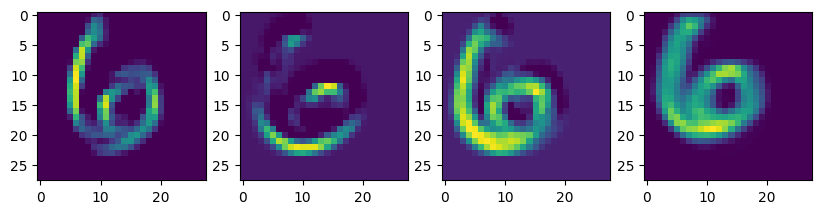

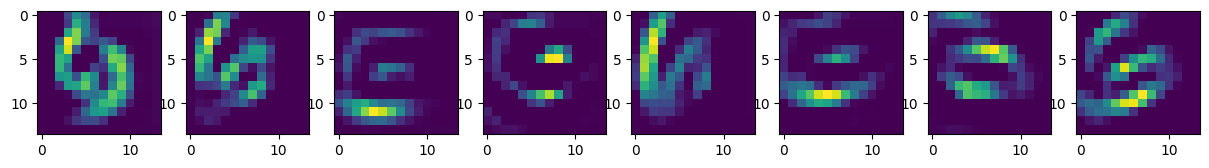

In [138]:
prediction = net(b.unsqueeze(0).unsqueeze(0))

pred = torch.max(prediction.data, 1)[1]
print('result: ', pred)  # 打印预测结果， 结果表明平移并不影响预测结果，证明池化操作进行了更大尺寸的特征提取，体现了健壮性

# 打印两层卷积层的特征图, 可以看到特征图也平移了
feature_maps = net.retrieve_features(b.unsqueeze(0).unsqueeze(0))
# 第一层卷积的特征图 (out_channels = 4)
out_channels = 4
plt.figure(figsize=(10, 7))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[0][0, i, ...].data.numpy())

# 第二层卷积的特征图（out_channels = 8）
out_channels = 8
plt.figure(figsize=(15, 10))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[1][0, i, ...].data.numpy())